In [88]:
%load_ext autoreload
%autoreload 2
# 
from srf.mixed.admm import run_cv_experiment, find_best_rank, admm_symnmf_masked, ADMM
from srf.helpers import evar
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tools.rsa import compute_similarity
from srf.mixed.admm import admm_symnmf_masked, train_val_split, ADMM
from srf.datasets import load_dataset
from srf.helpers import median_matrix_split, best_pairwise_match, zero_matrix_split
from srf.plotting import plot_images_from_embedding
import seaborn as sns

def plot_rank_selection(df_full, df_pos, df_neg):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    # Plot full dataframes with variance across repeats
    sns.lineplot(data=df_full, x="rank", y="rmse", ax=ax1, errorbar="sd")
    ax1.set_title("Full RSM")
    ax1.axvline(
        x=df_full.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )

    sns.lineplot(data=df_pos, x="rank", y="rmse", ax=ax2, errorbar="sd")
    ax2.set_title("Positive")
    ax2.axvline(
        x=df_pos.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )

    sns.lineplot(data=df_neg, x="rank", y="rmse", ax=ax3, errorbar="sd")
    ax3.set_title("Negative")
    ax3.axvline(
        x=df_neg.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )


    plt.tight_layout()
    plt.show()

    # Calculate best ranks using mean RMSE
    rank_pos = df_pos.groupby("rank")["rmse"].mean().idxmin()
    rank_neg = df_neg.groupby("rank")["rmse"].mean().idxmin()
    rank_all = df_full.groupby("rank")["rmse"].mean().idxmin()

    print(f"best rank for positive matrix: {rank_pos}")
    print(f"best rank for negative matrix: {rank_neg}")
    print(f"best rank for all matrix: {rank_all}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
dataset = load_dataset("peterson-animals")

images = dataset.images
rsm = dataset.rsm
n = rsm.shape[0]
repeats = 10
s_plus, s_minus, thresh, mask = median_matrix_split(rsm)

ratio = 0.3
df_full = find_best_rank(
    rsm,
    range(1, 30),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)
df_pos = find_best_rank(
    s_plus,
    range(1, 30),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)
df_neg = find_best_rank(
    s_minus,
    range(1, 30),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)

plot_rank_selection(df_full, df_pos, df_neg)

fraction of positive values: 0.5168055555555555


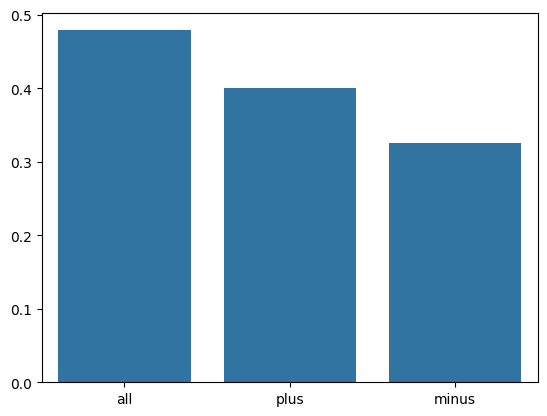

In [31]:
model = ADMM(rank=2, max_outer=10, w_inner=40, tol=0.0, verbose=False)
mask = np.ones_like(rsm)
model.fit(rsm, mask=mask)
evar_all = model.history_["evar"][-1]
model.fit(s_minus, mask=mask)
evar_minus = model.history_["evar"][-1]
model.fit(s_plus, mask=mask)
evar_plus = model.history_["evar"][-1]

# make a seaborn bar plot of the explain variance of the three matrices
sns.barplot(x=["all", "plus", "minus"], y=[evar_all, evar_plus, evar_minus])
plt.show()

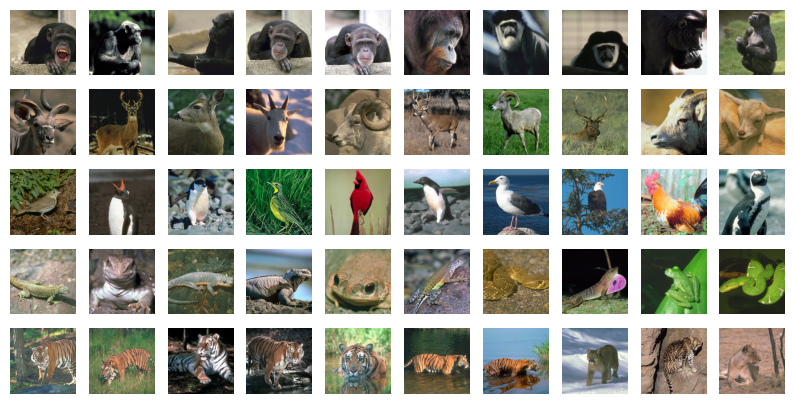

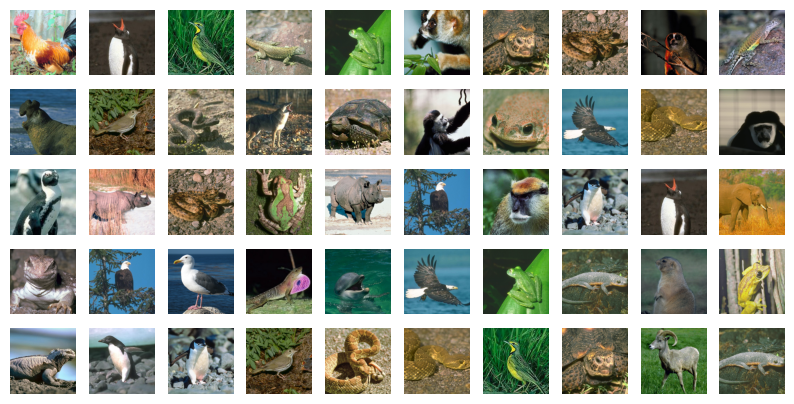

In [48]:
model = ADMM(rank=5, max_outer=100, w_inner=20, tol=0.0, verbose=True)
w_plus = model.fit_transform(s_plus)
w_minus = model.fit_transform(s_minus)

fig = plot_images_from_embedding(w_plus, images, top_k=10, dpi=100)
fig = plot_images_from_embedding(w_minus, images, top_k=10, dpi=100)

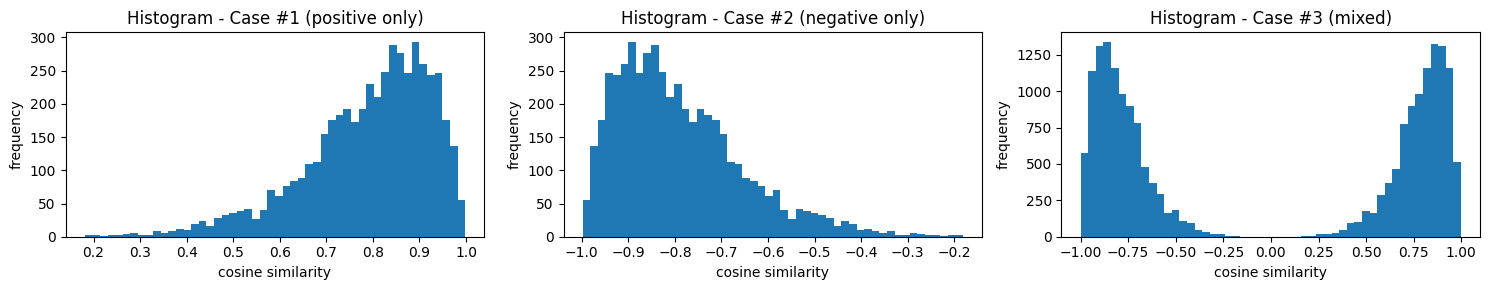

In [82]:
import numpy as np
import matplotlib.pyplot as plt

n_each = 100
dim = 5
bins = 50
rng = np.random.default_rng(0)

x_pos = rng.random((n_each, dim))
x_pos /= np.linalg.norm(x_pos, axis=1, keepdims=True)

x_neg = -x_pos
x_neg /= np.linalg.norm(x_neg, axis=1, keepdims=True)

rsm_pos = x_pos @ x_pos.T
rsm_neg = x_pos @ x_neg.T
x_all = np.vstack([x_pos, x_neg])
rsm_all = x_all @ x_all.T


def upper(vec):
    return vec[np.triu_indices_from(vec, k=1)]


fig, axes = plt.subplots(1, 3, figsize=(15, 3))

axes[0].hist(upper(rsm_pos), bins=bins)
axes[0].set_title("Histogram - Case #1 (positive only)")
axes[0].set_xlabel("cosine similarity")
axes[0].set_ylabel("frequency")

axes[1].hist(upper(rsm_neg), bins=bins)
axes[1].set_title("Histogram - Case #2 (negative only)")
axes[1].set_xlabel("cosine similarity")
axes[1].set_ylabel("frequency")

axes[2].hist(upper(rsm_all), bins=bins)
axes[2].set_title("Histogram - Case #3 (mixed)")
axes[2].set_xlabel("cosine similarity")
axes[2].set_ylabel("frequency")


plt.tight_layout()
plt.show()

fraction of positive values: 0.5


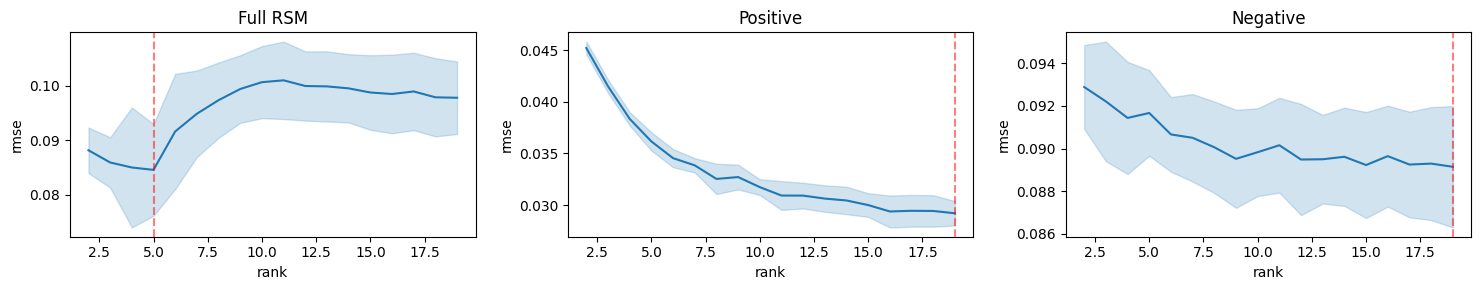

best rank for positive matrix: 19
best rank for negative matrix: 19
best rank for all matrix: 5


In [120]:
s_plus_plus, s_plus_minus, thresh_plus, mask_plus = median_matrix_split(rsm_pos)
ratio = 0.3
n_repeats = 5
df_full = find_best_rank(
    rsm_pos,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)
df_pos = find_best_rank(
    s_plus_plus,
    range(2, 20),
    mask=mask_plus,
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)
df_neg = find_best_rank(
    s_plus_minus,
    range(2, 20),
    mask=~mask_plus,
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)
plot_rank_selection(df_full, df_pos, df_neg)

fraction of positive values: 0.5


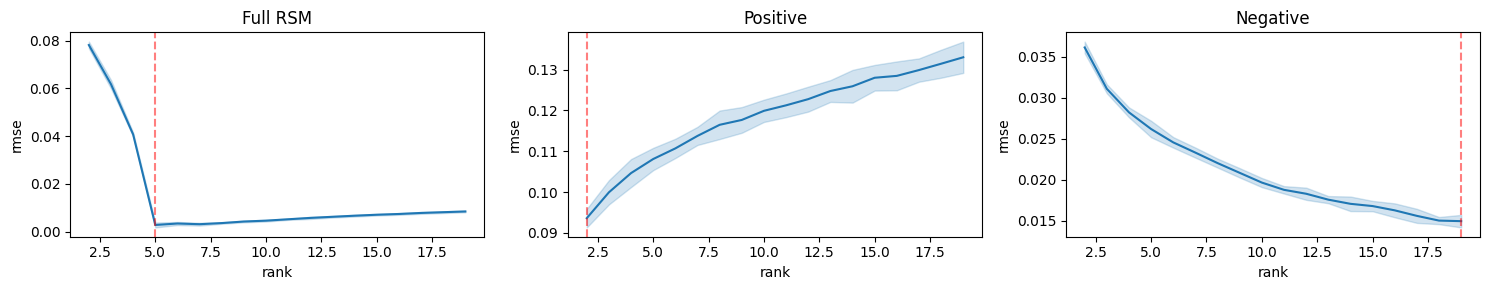

best rank for positive matrix: 2
best rank for negative matrix: 19
best rank for all matrix: 5


In [116]:
s_minus_plus, s_minus_minus, thresh_minus, mask_minus = median_matrix_split(rsm_neg)
ratio = 0.7
n_repeats = 10
df_full = find_best_rank(
    rsm_pos,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)
df_pos = find_best_rank(
    s_minus_plus,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)
df_neg = find_best_rank(
    s_minus_minus,
    range(2, 20),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)
plot_rank_selection(df_full, df_pos, df_neg)

In [106]:
model = ADMM(rank=5, max_outer=30, w_inner=20, tol=0.0, verbose=True)
w_pos = model.fit_transform(s_plus, mask=mask)
w_neg = model.fit_transform(s_minus, mask=~mask)

s_hat = w_pos @ w_pos.T - w_neg @ w_neg.T
print(evar(rsm_all, s_hat))

0.28525310611100210.359081 | Evar: 0.994843 | Recon: 0.372463 | Penalty: 0.000520 | Lag: -0.013902149780166


In [135]:
# things-monkye
dataset = load_dataset("things-monkey-2k")

rsm = dataset.rsm
rsm_pos = (rsm - rsm.min()) / (rsm.max() - rsm.min())
n = rsm.shape[0]
repeats = 3

ratio = 0.2
df_full = find_best_rank(
    rsm_pos,
    range(5, 45, 10),
    train_ratio=ratio,
    similarity_measure="linear",
    n_repeats=repeats,
)

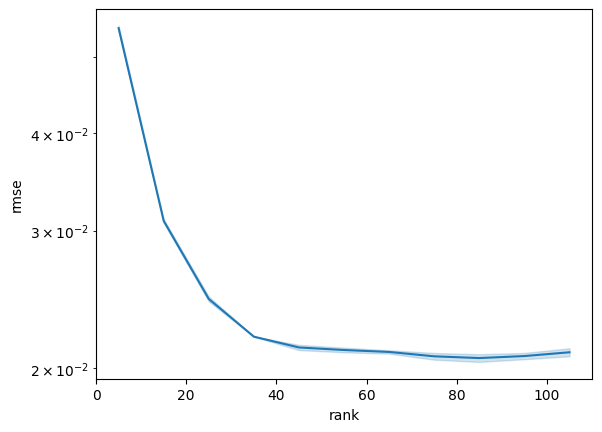

In [140]:
sns.lineplot(data=df_full, x="rank", y="rmse", errorbar="sd")
plt.yscale("log")
plt.show()